In [2]:
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
import IRF_Simulator as irfsim
import mat73

In [3]:
data = mat73.loadmat('DTOFs_2-24-2025_fine.mat')

In [4]:
uas = data['ua'].reshape(-1)
upss = data['ups'].reshape(-1)
rhos = data['rho'].reshape(-1)
dtofs = data['DTOF']
cfg = data['cfg']
print(cfg)
print(rhos)

{'autopilot': array(1.), 'bc': 'aaaaar', 'detpos': array([[160.        , 100.        ,   0.        ,   1.        ],
       [159.87920059, 103.80543518,   0.        ,   1.        ],
       [159.51728877, 107.59554721,   0.        ,   1.        ],
       [158.91572184, 111.35507466,   0.        ,   1.        ],
       [158.07692208, 115.06887923,   0.        ,   1.        ],
       [157.00426706, 118.72200674,   0.        ,   1.        ],
       [155.70207598, 122.29974734,   0.        ,   1.        ],
       [154.1755923 , 125.78769473,   0.        ,   1.        ],
       [152.43096262, 129.17180417,   0.        ,   1.        ],
       [150.47521197, 132.43844905,   0.        ,   1.        ],
       [148.31621545, 135.57447574,   0.        ,   1.        ],
       [145.96266659, 138.56725658,   0.        ,   1.        ],
       [143.42404229, 141.40474069,   0.        ,   1.        ],
       [140.71056469, 144.07550252,   0.        ,   1.        ],
       [137.83316003, 146.56878786,   0

In [6]:
np.shape(dtofs)

(256, 1000, 1000, 6)

In [16]:
cfg["tend"]

array(5.e-09)

ua = 0.002, ups = 0.2, rho = 35.0, tend = 5e-09


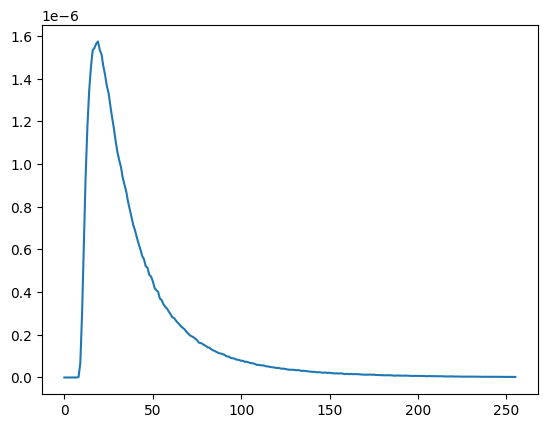

In [17]:
simId = [0,0,3]
ua = uas[simId[0]]
ups = upss[simId[1]]
rho = rhos[simId[2]]
print("ua = {}, ups = {}, rho = {}, tend = {}".format(ua, ups, rho, (cfg["tend"])))

dtof = dtofs[:,simId[0],simId[1],simId[2]]
plt.plot(dtof)

In [18]:
from scipy.interpolate import interp1d

# Define the new size
n_channels = 4096

# Get the current size of dtof
current_size = dtof.shape[0]

# Create an array of indices for the current and new sizes
current_indices = np.arange(current_size)
new_indices = np.linspace(0, current_size - 1, n_channels)

# Create an interpolation function
interpolation_function = interp1d(current_indices, dtof, kind='cubic')

# Interpolate dtof to the new size
dtof_interpolated = interpolation_function(new_indices)

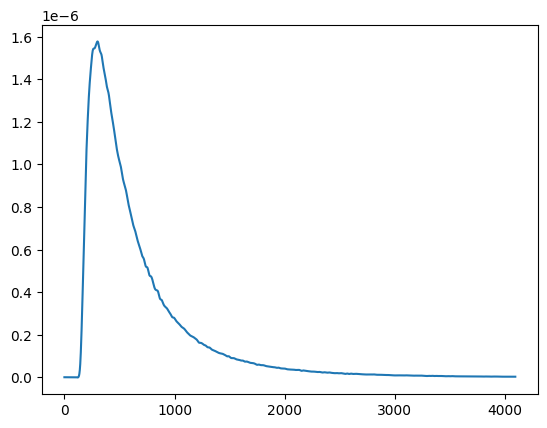

In [19]:
plt.plot(dtof_interpolated)

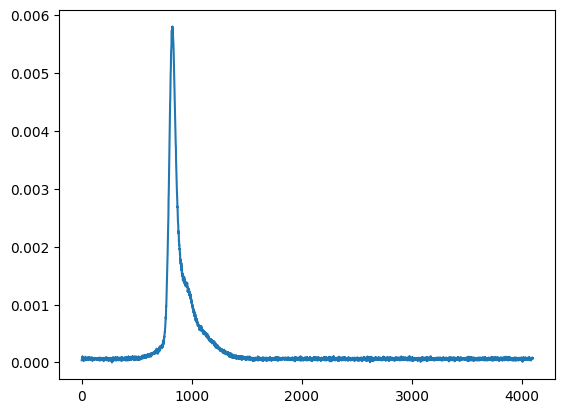

In [20]:
irf, irf_times = irfsim.generate_instrument_function_multi_peak(
    photon_count=2000000,   
    time_range_ns=25,
    time_resolution_ps=6.1,
    peak_widths_ps=[350.0, 550, 700.0, 2500],
    jitter_std_dev_ps=30.0,
    detector_response_type="gaussian",
    detector_response_params={'fwhm_ps': 40.0},
    peak_delays_ps=[5000, 5200, 5800, 6000],
    peak_ratios=[1.0, 0.6, 0.3, 1],
    avg_noise_floor=200,
    sd_noise_floor=20
)

irf = irf - np.min(irf)
irf = irf / np.sum(irf)

plt.plot(irf)

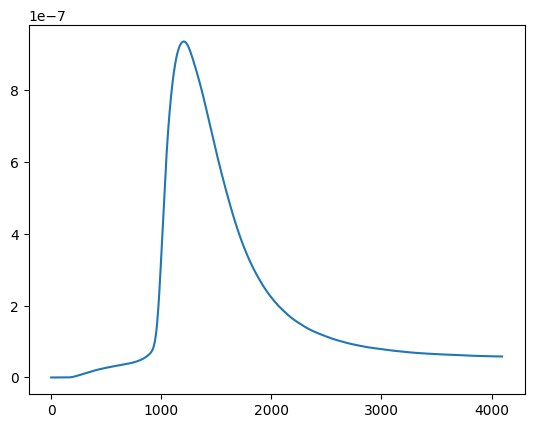

In [21]:
import scipy.signal as sig
datapoint = sig.convolve(dtof_interpolated, irf, mode='full')[:len(dtof_interpolated)]
plt.plot(datapoint)

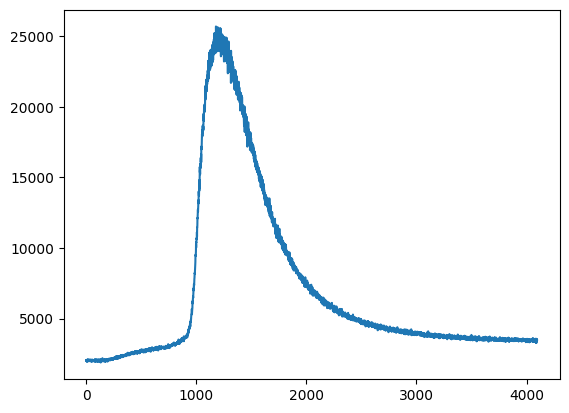

In [22]:
num_photons = 20000000
back_cte = 1e-9

datapoint = datapoint + back_cte
datapoint[datapoint < 0] = 0
probabilities = datapoint / np.sum(datapoint)

# Generate random times of flight based on the distribution
bins = np.arange(len(datapoint))
simulated_arrival_times = np.random.choice(bins, size=num_photons, p=probabilities)

n_channels = 4096
simulated_phd = np.histogram(simulated_arrival_times, bins=n_channels)[0]
simulated_mult_noise = np.random.normal(loc=1, scale=0.02, size=n_channels)
simulated_add_noise = np.random.poisson(lam=2000, size=n_channels)
simulated_phd = simulated_phd*simulated_mult_noise + simulated_add_noise
simulated_phd[simulated_phd < 0] = 0


plt.plot(simulated_phd)